In [1]:
import sys
import os

In [2]:
if 'google.colab' in sys.modules:
    os.system('apt install python3-mpi4py cython3 libxc-dev gpaw-data')
    os.system('pip install --upgrade gpaw pymatgen')

In [3]:
from ase.build import bulk
from ase.atom import Atom
from ase.atoms import Atoms
from gpaw import GPAW, PW
from ase.visualize.plot import plot_atoms
from ase.visualize import view
import numpy as np
from tqdm.auto import tqdm
from ase.eos import EquationOfState
import matplotlib.pyplot as plt
plt.style.use('default')
plt.rc('font', size=20)
plt.rc('figure', figsize=(18,6))

In [4]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


Defino otras funciones de conveniencia:

In [5]:
# Para graficar convergencia de energía.
def econvergence(E: list):
    return np.abs((E[:-1] - E[-1])/E[-1])

# Para almacenar cálculos.
def load_calc(filename, **kwargs):
    if os.path.exists(filename):
        calc = GPAW(filename)
    else:
        calc = GPAW(**kwargs)
    return calc

# Para borrar elementos del diccionario.
def removekey(d, key):
    r = dict(d)
    del r[key]
    return r
        

In [6]:
ECUT = 450

# Ecuación de Estado 

## **Si puro**

Tomo los resultados del archivo correspondiente.

Energía mínima.

In [7]:
E_Si_puro = -43.19552566832418

Parámetro de red que minimiza la energía (**parámetro de red en equilibrio**).

In [8]:
a_Si_puro = 5.475536578657841 

## **Si7B1**

Tomo los resultados del archivo correspondiente.

Energía mínima.

In [9]:
E_Si_B = -42.4406721413218

Parámetro de red que minimiza la energía (**parámetro de red en equilibrio**).

In [10]:
a_Si_B = 5.332820307836372

## **Si7P1**

Tomo los resultados del archivo correspondiente.

Energía mínima.

In [11]:
E_Si_P = -42.84236496941143

Parámetro de red que minimiza la energía (**parámetro de red en equilibrio**).

In [12]:
a_Si_P = 5.431411160497274

# Densidad de Estados 

Se vuelven a definir las estructuras a considerar, pero esta vez empleando los parámetros previamente calculados correspondientes al estado de equilibrio. 

En pruebas anteriores, donde se empleó el valor de KPT que había convergido al inicio, los gráficos de la densidad de estados se observaban puntiagudos. Para suavizarlos, se redefinió $KPT = 31$, sólo por fines estéticos.

In [13]:
KPT = 31

## **Si puro**

In [14]:
eq_SiDiamond = bulk('Si','diamond', a=a_Si_puro, cubic=True)

In [15]:
printatoms = [print(at) for at in eq_SiDiamond]

Atom('Si', [0.0, 0.0, 0.0], index=0)
Atom('Si', [1.3688841446644602, 1.3688841446644602, 1.3688841446644602], index=1)
Atom('Si', [0.0, 2.7377682893289204, 2.7377682893289204], index=2)
Atom('Si', [1.3688841446644602, 4.10665243399338, 4.10665243399338], index=3)
Atom('Si', [2.7377682893289204, 0.0, 2.7377682893289204], index=4)
Atom('Si', [4.10665243399338, 1.3688841446644602, 4.10665243399338], index=5)
Atom('Si', [2.7377682893289204, 2.7377682893289204, 0.0], index=6)
Atom('Si', [4.10665243399338, 4.10665243399338, 1.3688841446644602], index=7)


In [16]:
# calc = GPAW(mode=PW(ECUT), xc='PBE', kpts=[KPT,KPT,KPT], txt='eq_SiDiamond.txt')
calc = load_calc('eq_SiDiamond.gpw', mode=PW(ECUT), xc='PBE', kpts=[KPT,KPT,KPT], txt='eq_SiDiamond.txt')
eq_SiDiamond.set_calculator(calc)
eq_SiDiamond.get_potential_energy()

-43.19616771973655

(!!!) **Observación:** No me dio igual que antes, me daba -43.1955, ¿es normal que esto suceda?

In [17]:
e_SiDiamond,dos_SiDiamond = eq_SiDiamond.calc.get_dos(npts=500)
ef_SiDiamond = eq_SiDiamond.calc.get_fermi_level()

Text(0.5, 1.0, 'Densidad de estados - Si puro')

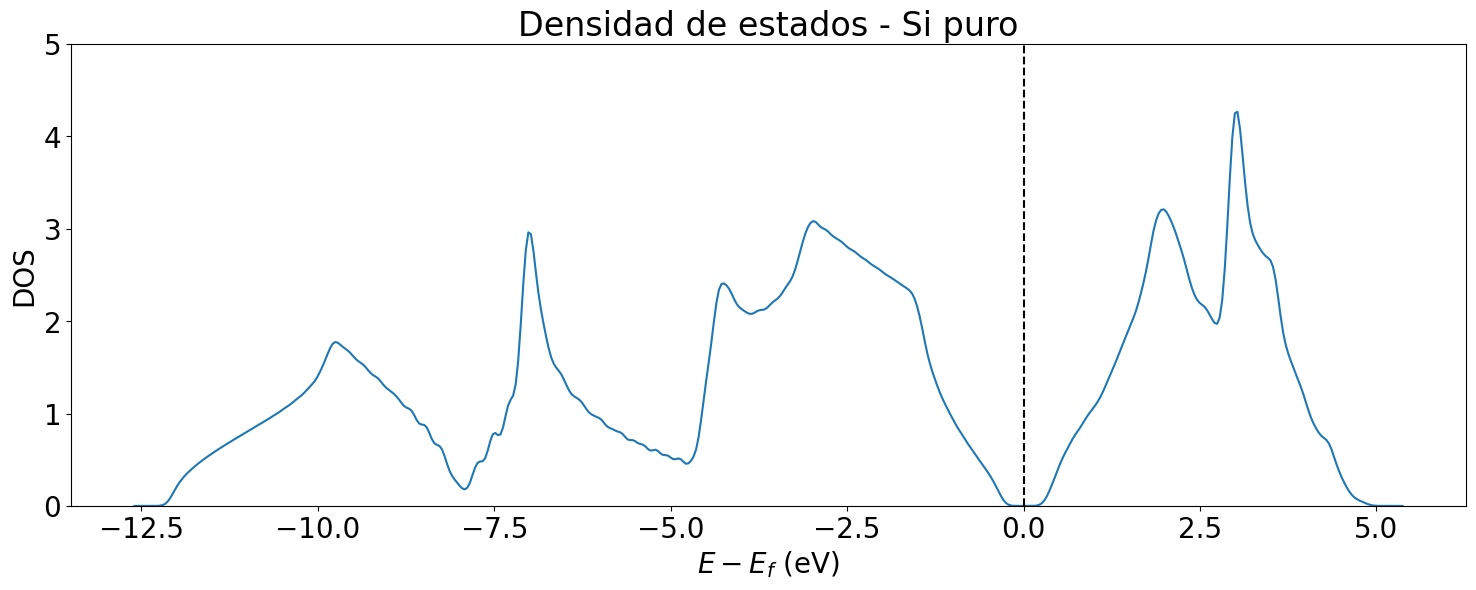

In [18]:
plt.plot(e_SiDiamond - ef_SiDiamond, dos_SiDiamond)
plt.ylim((0, 5))
plt.axvline(color='k', linestyle='--')
plt.xlabel('$E - E_f$ (eV)')
plt.ylabel('DOS')
plt.title('Densidad de estados - Si puro')

**Conclusión:** A la energía de Fermi no se encuentran estados disponibles para la conducción eléctrica, por lo que el **Si puro** se comporta como aislante eléctrico.

In [19]:
eq_SiDiamond.calc.write('eq_SiDiamond.gpw')

## **Si7B1**

In [20]:
# La defino sin dopar.
eq_SiBDiamond = bulk('Si','diamond', a=a_Si_B, cubic=True)

In [21]:
# Creo lista normal, con los elementos de la original "eq_SiDiamond".
eq_SiBDiamondList = [at for at in eq_SiBDiamond]
# Con "atom" defino el átomo de B, le asigno posición que tenía el Si en "eq_SiBDiamond", y guardo en la lista "eq_SiBDiamondList".
eq_SiBDiamondList[0] = Atom('B', position=eq_SiBDiamond[0].position)
# Con "atoms", defino la celda (igual a la de "eq_SiBDiamond", usando comando ".cell") con condiciones periódicas de borde en los 3 ejes (pbc=True), a partir
# de lo que contiene "eq_SiBDiamondList".
eq_SiBDiamond = Atoms(eq_SiBDiamondList, cell=eq_SiBDiamond.cell, pbc=True)

In [22]:
print_new_atoms = [print(at) for at in eq_SiBDiamond]

Atom('B', [0.0, 0.0, 0.0], index=0)
Atom('Si', [1.333205076959093, 1.333205076959093, 1.333205076959093], index=1)
Atom('Si', [0.0, 2.666410153918186, 2.666410153918186], index=2)
Atom('Si', [1.333205076959093, 3.9996152308772794, 3.9996152308772794], index=3)
Atom('Si', [2.666410153918186, 0.0, 2.666410153918186], index=4)
Atom('Si', [3.9996152308772794, 1.333205076959093, 3.9996152308772794], index=5)
Atom('Si', [2.666410153918186, 2.666410153918186, 0.0], index=6)
Atom('Si', [3.9996152308772794, 3.9996152308772794, 1.333205076959093], index=7)


In [23]:
# calc = GPAW(mode=PW(ECUT), xc='PBE', kpts=[KPT,KPT,KPT], txt='eq_SiBDiamond.txt')
calc = load_calc('eq_SiBDiamond.gpw', mode=PW(ECUT), xc='PBE', kpts=[KPT,KPT,KPT], txt='eq_SiBDiamond.txt')
eq_SiBDiamond.set_calculator(calc)
eq_SiBDiamond.get_potential_energy()

-42.440223687189146

(!!!) **Observación:** No me dio igual que antes, me daba -42.4406, ¿es normal que esto suceda?

In [24]:
e_SiBDiamond,dos_SiBDiamond = eq_SiBDiamond.calc.get_dos(npts=500)
ef_SiBDiamond = eq_SiBDiamond.calc.get_fermi_level()

Text(0.5, 1.0, 'Densidad de estados - Si$_7$B$_1$')

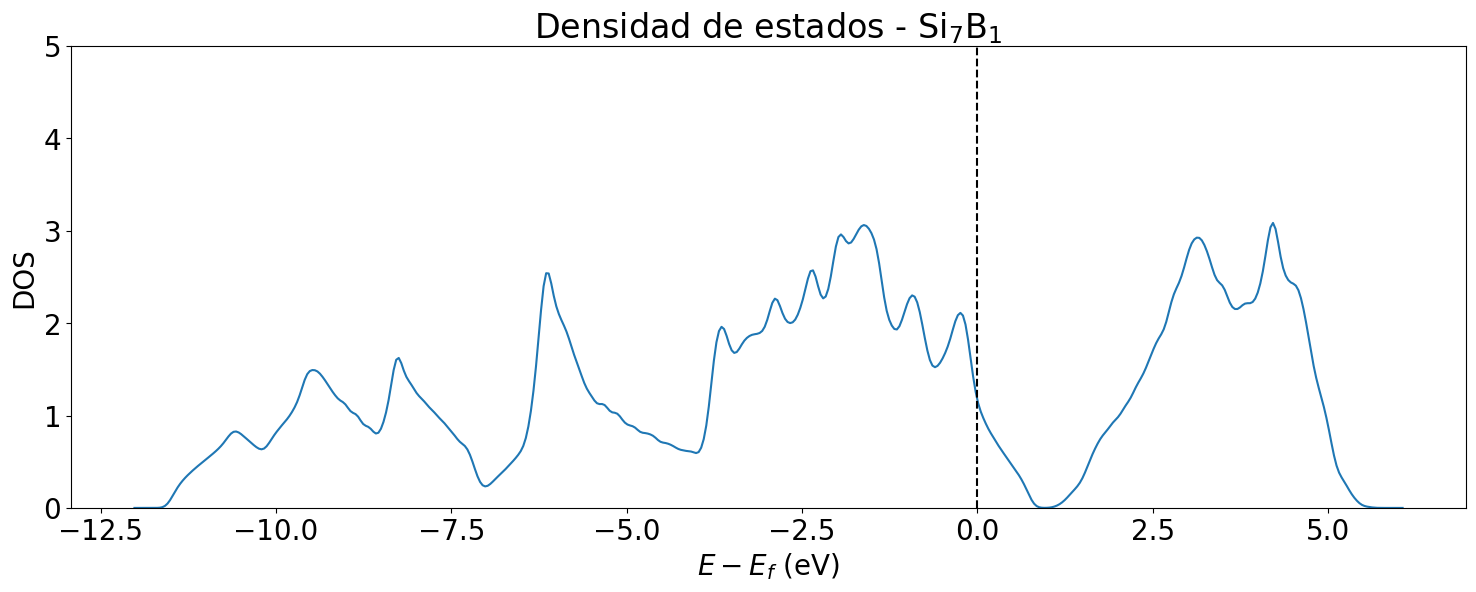

In [25]:
plt.plot(e_SiBDiamond - ef_SiBDiamond,dos_SiBDiamond)
plt.ylim((0, 5))
plt.axvline(color='k', linestyle='--')
plt.xlabel('$E - E_f$ (eV)')
plt.ylabel('DOS')
plt.title('Densidad de estados - Si$_7$B$_1$')

Se observa que los estados que permiten la conducción por huecos se han desplazado hacia mayores energías, de tal manera que algunos de ellos poseen la energía de Fermi. Esto no ocurría en el caso del Si puro.

**Conclusión:** A la energía de Fermi hay estados disponibles para la conducción eléctrica, por lo que el **Si7B1** se comporta como conductor eléctrico.

In [26]:
eq_SiBDiamond.calc.write('eq_SiBDiamond.gpw')

## **Si7P1**

In [27]:
# La defino sin dopar.
eq_SiPDiamond = bulk('Si','diamond', a=a_Si_P, cubic=True)

In [28]:
# Creo lista normal, con los elementos de la original "eq_SiPDiamond".
eq_SiPDiamondList = [at for at in eq_SiPDiamond]
# Con "atom" defino el átomo de P, le asigno posición que tenía el Si en "eq_SiPDiamond", y guardo en la lista "eq_SiPDiamondList".
eq_SiPDiamondList[0] = Atom('P', position=eq_SiPDiamond[0].position)
# Con "atoms", defino la celda (igual a la de "eq_SiPDiamond", usando comando ".cell") con condiciones periódicas de borde en los 3 ejes (pbc=True), a partir
# de lo que contiene "eq_SiPDiamondList".
eq_SiPDiamond = Atoms(eq_SiPDiamondList, cell=eq_SiPDiamond.cell, pbc=True)

In [29]:
print_new_atoms = [print(at) for at in eq_SiPDiamond]

Atom('P', [0.0, 0.0, 0.0], index=0)
Atom('Si', [1.3578527901243185, 1.3578527901243185, 1.3578527901243185], index=1)
Atom('Si', [0.0, 2.715705580248637, 2.715705580248637], index=2)
Atom('Si', [1.3578527901243185, 4.073558370372956, 4.073558370372956], index=3)
Atom('Si', [2.715705580248637, 0.0, 2.715705580248637], index=4)
Atom('Si', [4.073558370372956, 1.3578527901243185, 4.073558370372956], index=5)
Atom('Si', [2.715705580248637, 2.715705580248637, 0.0], index=6)
Atom('Si', [4.073558370372956, 4.073558370372956, 1.3578527901243185], index=7)


In [30]:
# calc = GPAW(mode=PW(ECUT), xc='PBE', kpts=[KPT,KPT,KPT], txt='eq_SiPDiamond.txt')
calc = load_calc('eq_SiPDiamond.gpw', mode=PW(ECUT), xc='PBE', kpts=[KPT,KPT,KPT], txt='eq_SiPDiamond.txt')
eq_SiPDiamond.set_calculator(calc)
eq_SiPDiamond.get_potential_energy()

-42.840847679414956

(!!!) **Observación:** No me dio igual que antes, me daba -42.8424, ¿es normal que esto suceda?

In [31]:
e_SiPDiamond,dos_SiPDiamond = eq_SiPDiamond.calc.get_dos(npts=500)
ef_SiPDiamond = eq_SiPDiamond.calc.get_fermi_level()

Text(0.5, 1.0, 'Densidad de estados - Si$_7$P$_1$')

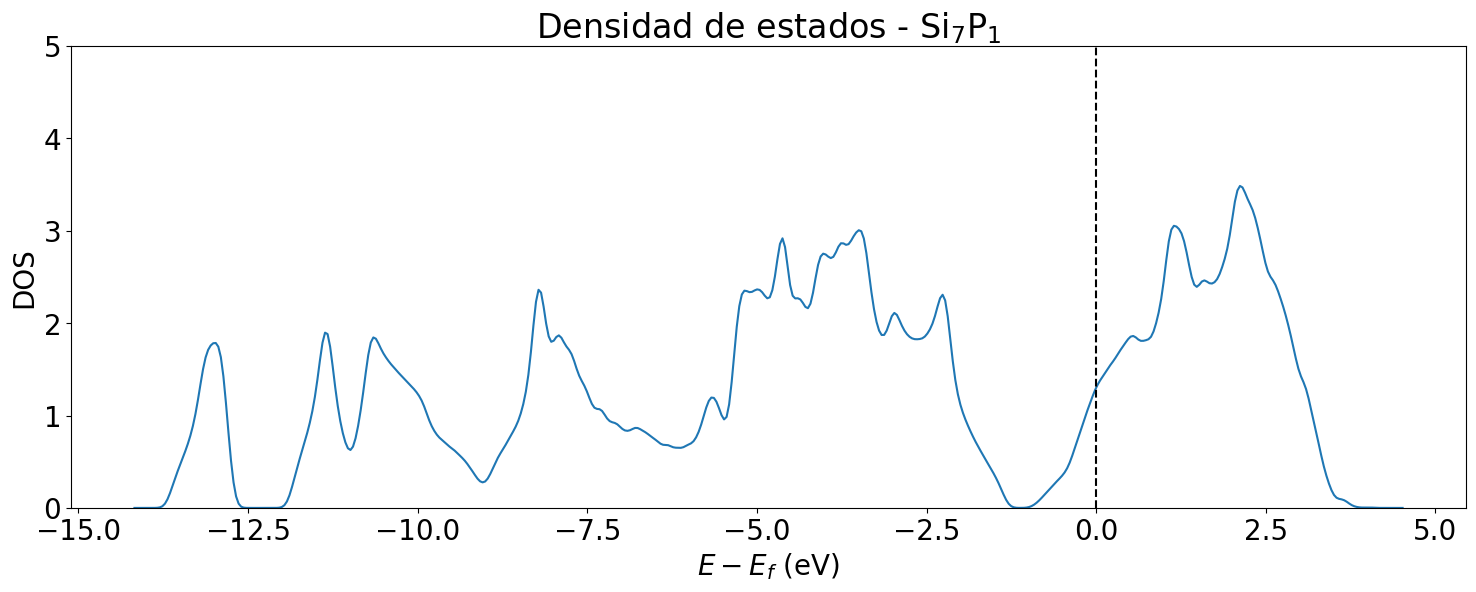

In [32]:
plt.plot(e_SiPDiamond - ef_SiPDiamond,dos_SiPDiamond)
plt.ylim((0, 5))
plt.axvline(color='k', linestyle='--')
plt.xlabel('$E - E_f$ (eV)')
plt.ylabel('DOS')
plt.title('Densidad de estados - Si$_7$P$_1$')

Se observa que los estados que permiten la conducción por electrones se han desplazado hacia menores energías, de tal manera que algunos de ellos poseen la energía de Fermi. Esto no ocurría en el caso del Si puro.

**Conclusión:** A la energía de Fermi hay estados disponibles para la conducción eléctrica, por lo que el **Si7P1** se comporta como conductor eléctrico.

In [33]:
eq_SiPDiamond.calc.write('eq_SiPDiamond.gpw')

## **SUPERPOSICIÓN de densidades de estado**

## Las 3 juntas

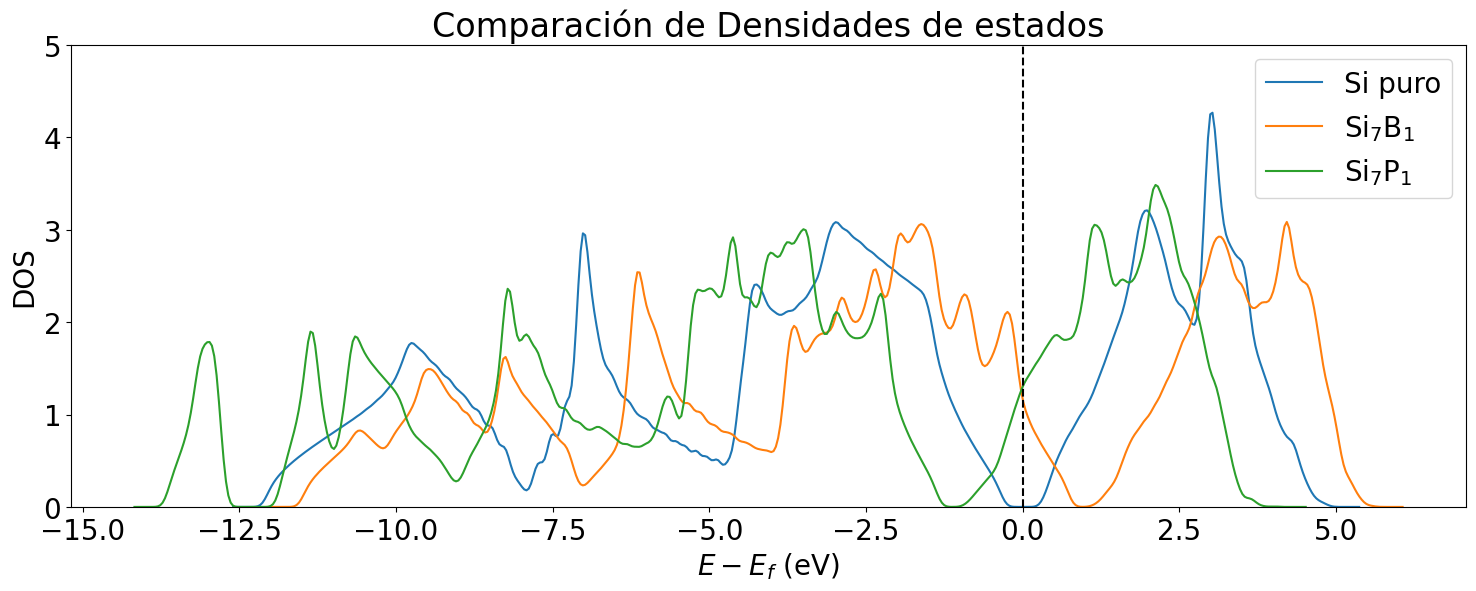

In [34]:
plt.plot(e_SiDiamond - ef_SiDiamond, dos_SiDiamond, label='Si puro')
plt.plot(e_SiBDiamond - ef_SiBDiamond, dos_SiBDiamond, label='Si$_7$B$_1$')
plt.plot(e_SiPDiamond - ef_SiPDiamond, dos_SiPDiamond, label='Si$_7$P$_1$')
plt.ylim((0, 5))
plt.axvline(color='k', linestyle='--')
plt.xlabel('$E - E_f$ (eV)')
plt.ylabel('DOS')
plt.title('Comparación de Densidades de estados')
plt.legend()

No es demasiado claro, así que graficaré diferente.

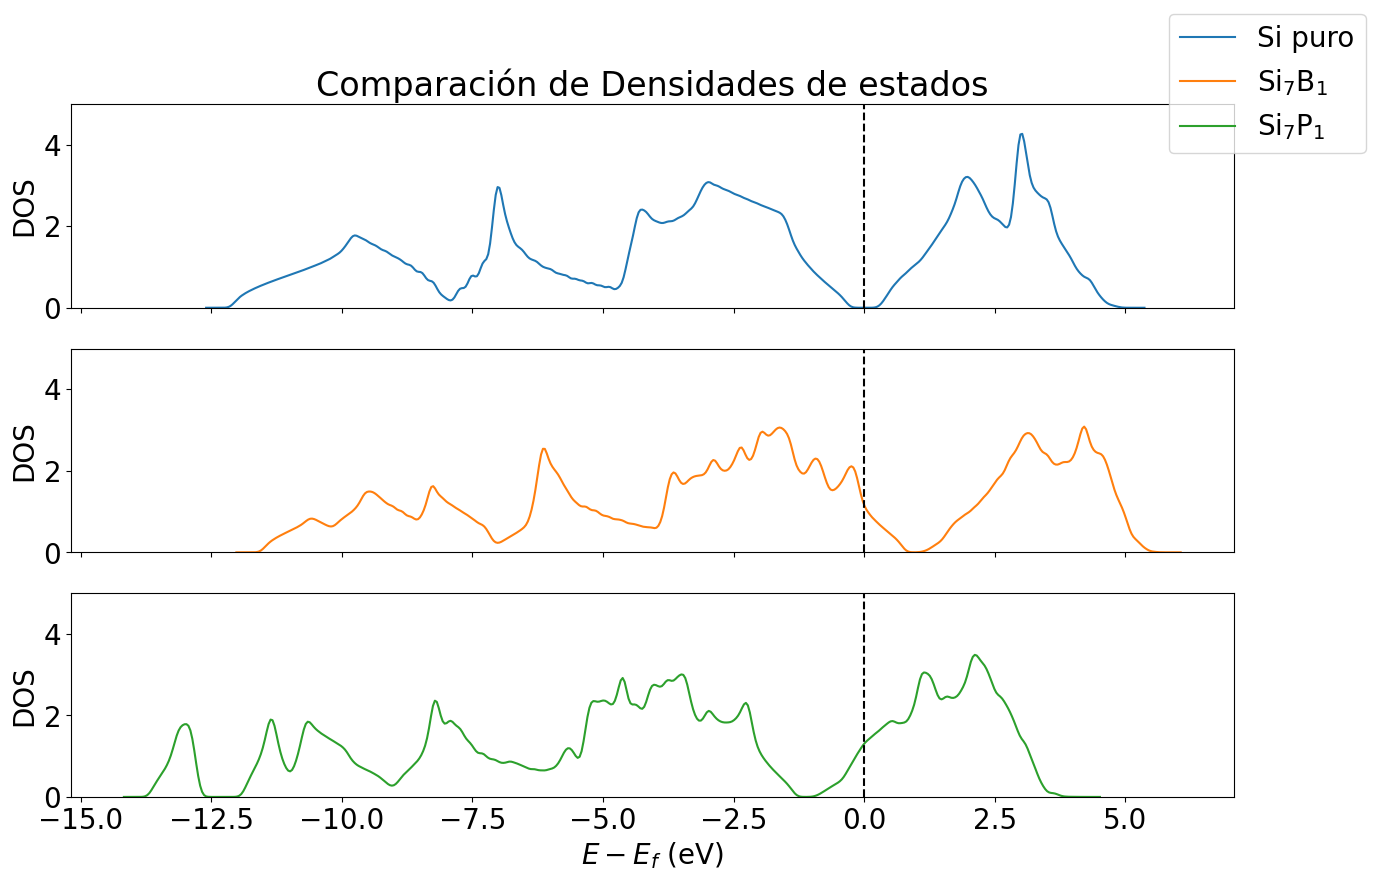

In [35]:
fig, ax = plt.subplots(3,1, figsize=(15,9), sharex=True)
ax[0].plot(e_SiDiamond - ef_SiDiamond, dos_SiDiamond, label='Si puro')
ax[1].plot(e_SiBDiamond - ef_SiBDiamond, dos_SiBDiamond, 'C1', label='Si$_7$B$_1$')
ax[2].plot(e_SiPDiamond - ef_SiPDiamond, dos_SiPDiamond, 'C2', label='Si$_7$P$_1$')
for i in range(3):
  ax[i].set_ylim((0, 5))
  ax[i].set_ylabel('DOS')
  ax[i].axvline(color='k', linestyle='--')
ax[2].set_xlabel('$E - E_f$ (eV)')
ax[0].set_title('Comparación de Densidades de estados')
fig.legend()

## De a 2

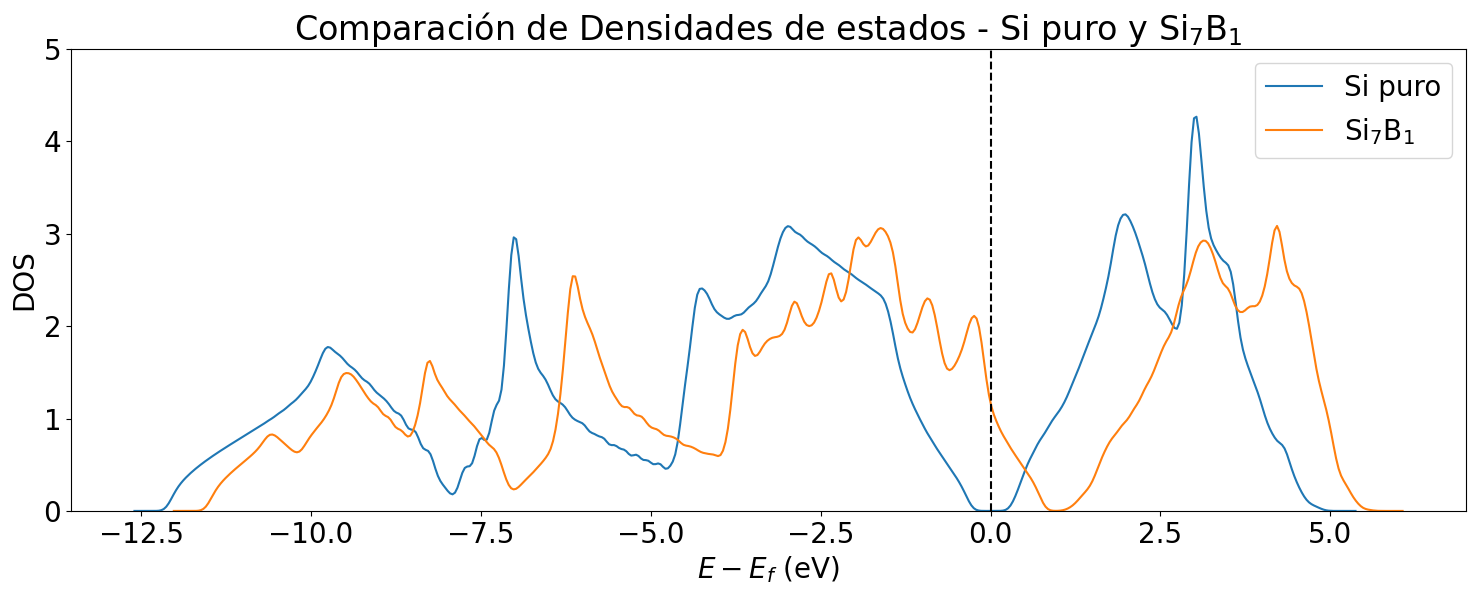

In [36]:
plt.plot(e_SiDiamond - ef_SiDiamond, dos_SiDiamond, label='Si puro')
plt.plot(e_SiBDiamond - ef_SiBDiamond, dos_SiBDiamond, label='Si$_7$B$_1$')
plt.ylim((0, 5))
plt.axvline(color='k', linestyle='--')
plt.xlabel('$E - E_f$ (eV)')
plt.ylabel('DOS')
plt.title('Comparación de Densidades de estados - Si puro y Si$_7$B$_1$')
plt.legend()

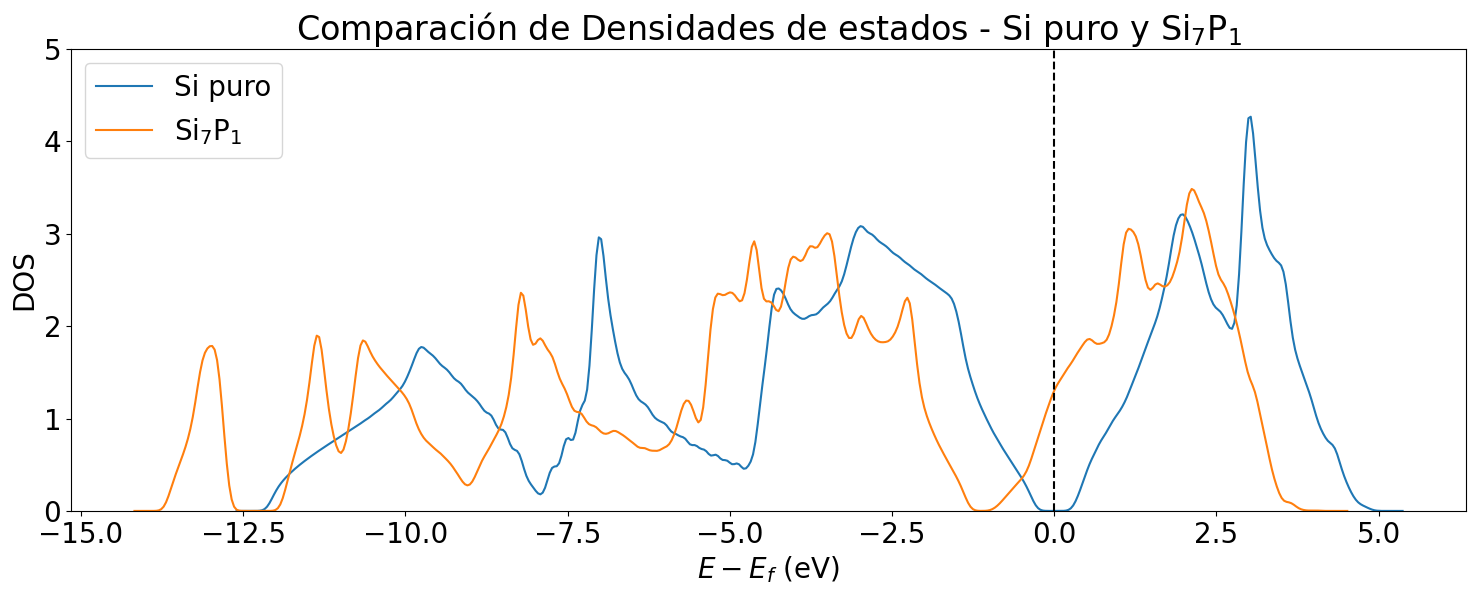

In [37]:
plt.plot(e_SiDiamond - ef_SiDiamond, dos_SiDiamond, label='Si puro')
plt.plot(e_SiPDiamond - ef_SiPDiamond, dos_SiPDiamond, label='Si$_7$P$_1$')
plt.ylim((0, 5))
plt.axvline(color='k', linestyle='--')
plt.xlabel('$E - E_f$ (eV)')
plt.ylabel('DOS')
plt.title('Comparación de Densidades de estados - Si puro y Si$_7$P$_1$')
plt.legend()